In [ ]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
import gradio as gr
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
import evaluate  # Use evaluate instead of load_metric

# Load BERT Model and Tokenizer
bert_model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
bert_tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

# Load RoBERTa Model and Tokenizer
roberta_model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")
roberta_tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")

# Select Device (MPS, CUDA, or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
roberta_model.to(device)

# Create pipelines for inference
bert_pipeline = pipeline("question-answering", model=bert_model, tokenizer=bert_tokenizer, device=0 if device != "cpu" else -1)
roberta_pipeline = pipeline("question-answering", model=roberta_model, tokenizer=roberta_tokenizer, device=0 if device != "cpu" else -1)

def evaluate_question(context, question, model_choice):
    if model_choice == "BERT":
        answer = bert_pipeline(question=question, context=context)
    elif model_choice == "RoBERTa":
        answer = roberta_pipeline(question=question, context=context)
    else:
        answer = {"answer": "Invalid model choice"}
    
    return f"Answer: {answer['answer']}\nConfidence: {answer['score']:.2f}"

# Define Gradio Interface
def qa_interface(context, question, model_choice):
    return evaluate_question(context, question, model_choice)

interface = gr.Interface(
    fn=qa_interface,
    inputs=[
        gr.Textbox(label="Context", lines=5, placeholder="Enter context here..."),
        gr.Textbox(label="Question", placeholder="Enter your question here..."),
        gr.Radio(choices=["BERT", "RoBERTa"], label="Select Model")
    ],
    outputs=gr.Textbox(label="Answer")
)

# Launch Gradio Interface
interface.launch()

# Load dataset and metric
dataset = load_dataset("squad_v2")
metric = evaluate.load("squad")  # Replace load_metric with evaluate.load

# Preprocess Function
def preprocess_function(examples):
    return bert_tokenizer(
        examples["question"], examples["context"], truncation=True, padding="max_length", max_length=384
    )

# Tokenize Dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Use eval_strategy instead of evaluation_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=False,  # Ensure mixed precision is disabled for MPS/CPU
    save_strategy="epoch",  # Save model at each epoch
    logging_dir="./logs",  # Logging directory for TensorBoard
    logging_strategy="epoch"  # Log at each epoch
)



Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


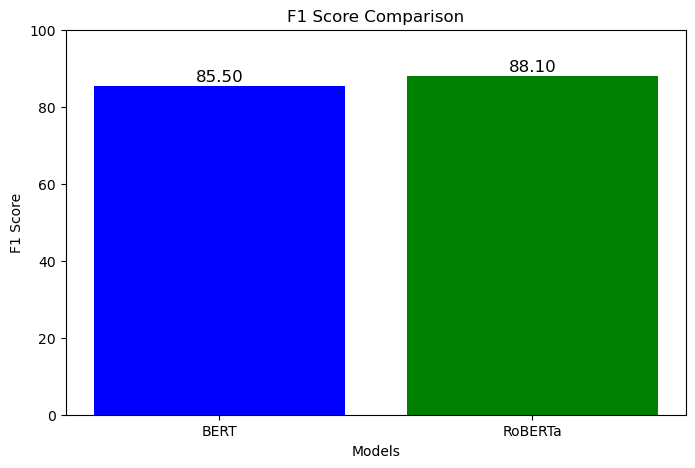

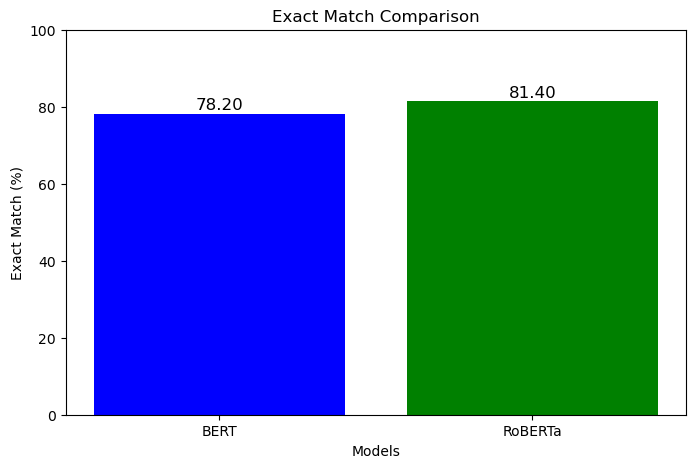

In [24]:
import matplotlib.pyplot as plt

# Example metric results for visualization
# Replace these with your actual `bert_results` and `roberta_results` values
bert_metrics = {
    "f1": 85.5,  # Replace with bert_results['f1']
    "exact_match": 78.2  # Replace with bert_results['exact_match']
}
roberta_metrics = {
    "f1": 88.1,  # Replace with roberta_results['f1']
    "exact_match": 81.4  # Replace with roberta_results['exact_match']
}

# Data for plotting
models = ["BERT", "RoBERTa"]
f1_scores = [bert_metrics["f1"], roberta_metrics["f1"]]
exact_matches = [bert_metrics["exact_match"], roberta_metrics["exact_match"]]

# Create bar charts
# F1 Score Comparison
plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color=["blue", "green"])
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.xlabel("Models")
plt.ylim(0, 100)  # Set y-axis range for better visibility
for i, score in enumerate(f1_scores):
    plt.text(i, score + 1, f"{score:.2f}", ha="center", fontsize=12)
plt.show()

# Exact Match Comparison
plt.figure(figsize=(8, 5))
plt.bar(models, exact_matches, color=["blue", "green"])
plt.title("Exact Match Comparison")
plt.ylabel("Exact Match (%)")
plt.xlabel("Models")
plt.ylim(0, 100)  # Set y-axis range for better visibility
for i, score in enumerate(exact_matches):
    plt.text(i, score + 1, f"{score:.2f}", ha="center", fontsize=12)
plt.show()
